In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:

def place_cell_masks(sess):
    if sess.novel_arm == -1:
        if 'right' in sess.place_cell_info.keys():
            fammask = sess.place_cell_info['right']['masks']
            novmask = sess.place_cell_info['left']['masks']
        else:
            if len(sess.place_cell_info[1]['masks'].shape)>1:
                print('multi-sess pc')
                print(sess.place_cell_info[1]['masks'].shape)
                fammask = sess.place_cell_info[1]['masks'].sum(axis=0)>0
                novmask = sess.place_cell_info[-1]['masks'].sum(axis=0)>0
            else:
                fammask = sess.place_cell_info[1]['masks']
                novmask = sess.place_cell_info[-1]['masks']
    else:
        if 'right' in sess.place_cell_info.keys():
            novmask = sess.place_cell_info['right']['masks']
            fammask = sess.place_cell_info['left']['masks']
        else:
            if len(sess.place_cell_info[1]['masks'].shape)>1:
                print('multi-sess pc')
                novmask = sess.place_cell_info[1]['masks'].sum(axis=0)>0
                fammask = sess.place_cell_info[-1]['masks'].sum(axis=0)>0
            else:
                novmask = sess.place_cell_info[1]['masks']
                fammask = sess.place_cell_info[-1]['masks']
    return fammask,novmask
        
def out_of_field_ratio(sess, fam = True):
    if fam:
        cellmask, _ = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==-1*sess.novel_arm
        
    else:
        _,cellmask = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
    trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    trial_mat[np.isnan(trial_mat)]=1E-5
    trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)

    avg_rate_map = np.nanmean(trial_mat,axis=0)
    avg_rate_map_prob = avg_rate_map/(avg_rate_map.sum(axis=0,keepdims=True)+1E-5)
    norm_rate_map = (avg_rate_map-np.amin(avg_rate_map,axis=0,keepdims=True))/(np.amax(avg_rate_map,axis=0,keepdims=True)-np.amin(avg_rate_map,axis=0,keepdims=True))
    peak_inds = np.argmax(avg_rate_map,axis=0)[np.newaxis,:]
    half_max = norm_rate_map<=.5

    inds = np.arange(0,norm_rate_map.shape[0])[:,np.newaxis]
    left_mask = half_max*(inds<peak_inds)
    right_mask = half_max*(inds>peak_inds)

    left_edge = np.zeros([norm_rate_map.shape[-1],],dtype=np.int)
    right_edge = np.zeros([norm_rate_map.shape[-1],],dtype=np.int)+norm_rate_map.shape[0]
    field_mask = np.zeros(avg_rate_map.shape)>1
    for cell in range(trial_mat.shape[-1]):
        l_edge = np.argwhere(left_mask[:,cell].ravel())                  
        if l_edge.shape[0]>0:
            left_edge[cell] = l_edge[-1]



        r_edge = np.argwhere(right_mask[:,cell].ravel())                  
        if r_edge.shape[0]>0:
            right_edge[cell] = r_edge[0]

        field_mask[left_edge[cell]:right_edge[cell],cell] = True

    outfield = np.zeros([trial_mat.shape[0],trial_mat.shape[-1]])
    infield = np.zeros([trial_mat.shape[0],trial_mat.shape[-1]])
    
    avg_outfield = np.zeros([trial_mat.shape[-1],])
    avg_infield = np.zeros([trial_mat.shape[-1],])
    for cell in range(trial_mat.shape[-1]):

        infield[:,cell] = np.nansum(trial_mat_norm[:,field_mask[:,cell],cell], axis=-1)
        outfield[:,cell] =  np.nansum(trial_mat_norm[:,~field_mask[:,cell],cell], axis=-1)
                           
        avg_infield[cell] = np.nanmean(avg_rate_map[field_mask[:,cell],cell], axis=-1)
        avg_outfield[cell] =  np.nanmean(avg_rate_map[~field_mask[:,cell],cell], axis=-1)
    return np.log(infield+1E-5) - np.log(outfield+1E-5), np.log(avg_infield)-np.log(avg_outfield), field_mask

def lap_stats(sess, fam = True, placecells = True):
    
    if fam:
        cellmask, _ = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==-1*sess.novel_arm
        
    else:
        _,cellmask = place_cell_masks(sess)
        trialmask = sess.trial_info['LR']==sess.novel_arm
        
    if not placecells:
        cellmask = np.zeros(cellmask.shape)<1
        
    trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    trial_mat[np.isnan(trial_mat)]=1E-5
    avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)
    
    trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat,2,axis=0)
    trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)
    
    
    avg_trial_mat_sm = sp.ndimage.filters.gaussian_filter1d(avg_trial_mat,1,axis=1)
    extm = sp.signal.argrelmax(avg_trial_mat_sm,axis=1)[2]
    max_counts = np.bincount(extm)
    
    
    avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)

    inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
    com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
    std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
    
    skewness = (np.power((inds-com)/(std+1E-5),3)*trial_mat_norm).sum(axis=1)
    kurtosis = (np.power((inds-com)/(std+1E-5),4)*trial_mat_norm).sum(axis=1)
    

    avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
    avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

    avg_skewness = (np.power((inds-avg_com)/(avg_std+1E-5),3)*avg_trial_mat_norm).sum(axis=1)
    avg_kurtosis = (np.power((inds-avg_com)/(avg_std+1E-5),4)*avg_trial_mat_norm).sum(axis=1)
    
    return {'com': com, 
            'std': std, 
            'skewness': skewness,
            'kurtosis': kurtosis,
            'avg_com': avg_com.ravel(), 
            'avg_std': avg_std.ravel(), 
            'avg_skewness': avg_skewness.ravel(),
            'avg_kurtosis': avg_kurtosis.ravel(),
            'avg_entropy': sp.stats.entropy(avg_trial_mat[0,:,:],axis=0),
            'max_counts': max_counts}

def avg_stats_violinplots(ko_dict, ctrl_dict, data_key):
    fig,ax = plt.subplots(figsize= [15,5])
    
    n_days = len(ko_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice)])
    for k, (mouse, data_list) in enumerate(ko_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
        
            ko_means[day,k]=data.mean()
            parts = ax.violinplot(data,positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .1*k, data.mean(),color='red')
            for pc in parts['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

    ctrl_means = np.zeros([n_days,len(ctrl_mice)])
    for k, (mouse, data_list) in enumerate(ctrl_dict.items()):
        for day, data_dict in enumerate(data_list):
            data = data_dict[data_key]
            
            ctrl_means[day,k] = data.mean()
            
            parts = ax.violinplot(data,positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .6+ .1*k, data.mean(),color='black')
            for pc in parts['bodies']:
                pc.set_facecolor('black')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

        
    
        
    t,p = sp.stats.ttest_ind(ko_means,ctrl_means,axis=1)
    print(t,p)
    
    p = [sp.stats.ranksums(ko_means[i,:],ctrl_means[i,:])[1] for i in range(5)]
    print(p)
    return (fig, ax), ko_means, ctrl_means, (t,p)


In [3]:
single_mouse_lap_stats = lambda mouse, days, fam: [lap_stats(u.load_single_day(mouse,day=day), placecells=True, fam=fam) for day in days] 

ko_fam_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6),True) for mouse in ko_mice}
ctrl_fam_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), True) for mouse in ctrl_mice}

ko_nov_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), False) for mouse in ko_mice}
ctrl_nov_lap_stats = {mouse: single_mouse_lap_stats(mouse, range(6), False) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel': 1, '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1,

[2.37839268 2.35655248 3.48389819 3.36848737 2.78363835 3.28670376] [0.04465757 0.04620621 0.00827216 0.00980755 0.02379063 0.01107639]
[0.04720176769014221, 0.04720176769014221, 0.016293603621028527, 0.009023438818080326, 0.016293603621028527]
[[8.39044292 8.29725117 8.20476371 8.08102476 8.27882985]
 [8.30883445 8.22869147 8.08529598 7.87741952 8.19340097]
 [8.14390788 7.97074567 8.03518356 7.88464544 8.10648704]
 [7.99675108 8.23203631 8.02588918 7.95542349 8.13335867]
 [8.04650887 8.00511039 8.0559268  7.93693307 8.04541138]
 [8.14911166 7.95526882 7.80237044 7.96681261 8.05057463]] [[7.92904469 8.10383602 8.18581828 7.75251545 8.14364371]
 [7.4447056  7.98457774 8.06494516 7.53926931 7.93637209]
 [7.53867137 7.55762956 7.86850474 7.76394884 7.88469348]
 [7.70440791 7.88987624 7.9446231  7.85568053 7.86582172]
 [7.63582045 7.85829511 8.00203519 7.72054536 7.90909993]
 [7.52929816 7.39068168 7.70330817 7.75709419 7.86582657]]


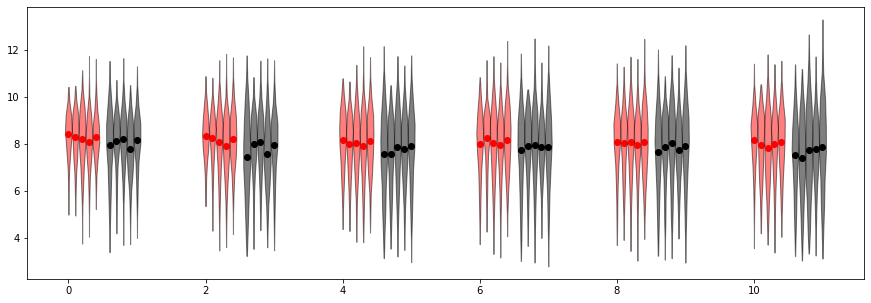

In [4]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'avg_std')
print(ko_means,ctrl_means)

In [7]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)

print('Tukey on each day')
for day in range(6):
    stats = pairwise_tukey(data= df[df['day']==day], dv='std', between = 'ko_ctrl')
    print(stats)
    
print('Tukey on days')
stats = pairwise_tukey(data= df, dv='std', between = 'day')
print(stats)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  1.097235    1    8  1.097235  13.471470  0.006306  0.627413   
1          day  0.592012    5   40  0.118402   9.464668  0.000005  0.541932   
2  Interaction  0.054409    5   40  0.010882   0.869848  0.509852  0.098068   

        eps  
0       NaN  
1  0.484198  
2       NaN  
Tukey test on groups
   A  B  mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  8.08148  7.81102  0.270461  0.045466  5.948667    0.001  1.515992
Tukey on each day
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  8.250462  8.022972  0.227491  0.095649  2.378393  0.044657  1.358657
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  8.138728  7.793974  0.344754  0.146296  2.356552  0.046206  1.346181
   A  B   mean(A)  mean(B)      diff       se         T   p-tukey    hedges
0  0  1  8.028194  7.72269  0.305504  0.08769  3.4

[3.27509662 3.11280371 4.03345257 3.20142152 3.2397668  3.52809266] [0.01127005 0.01438436 0.00376991 0.01258544 0.01188178 0.00775359]
[0.016293603621028527, 0.028280122568276955, 0.009023438818080326, 0.016293603621028527, 0.016293603621028527]
[[8.32285096 7.9407238  7.63016916 7.8496664  8.02405125]
 [7.98582554 7.79440289 7.55770513 7.48470485 7.94815624]
 [7.77478602 7.81217601 7.61722729 7.62235023 8.05194125]
 [7.64411608 7.84840375 7.5966345  7.70509195 7.99407511]
 [7.684112   7.84153257 7.61825148 7.5926322  7.8716447 ]
 [8.15088108 8.19889538 7.65503361 7.97692756 8.30231897]] [[7.09520011 7.61507639 7.35253533 7.56765746 7.63411868]
 [7.06296493 7.48683793 7.50800305 7.38051421 7.32859835]
 [7.06414626 7.4994362  7.4158372  7.41463756 7.22544663]
 [7.08283181 7.11962892 7.22253782 7.5496798  7.64212726]
 [7.01793193 7.53403866 7.29003831 7.16115434 7.59907748]
 [7.44668541 7.06967496 7.5001532  7.76121955 7.63470111]]


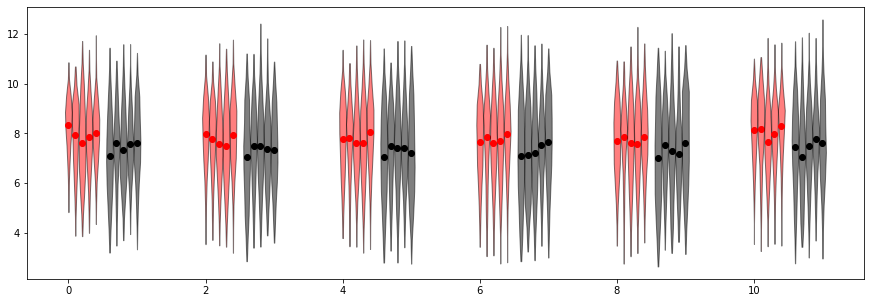

In [8]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'avg_std')
print(ko_means,ctrl_means)

In [9]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)

print('Tukey on each day')
for day in range(6):
    stats = pairwise_tukey(data= df[df['day']==day], dv='std', between = 'ko_ctrl')
    print(stats)
    
print('Tukey on days')
stats = pairwise_tukey(data= df, dv='std', between = 'day')
print(stats)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  3.180810    1    8  3.180810  20.424576  0.001952  0.718553   
1          day  0.536222    5   40  0.107244   4.253393  0.003401  0.347120   
2  Interaction  0.056023    5   40  0.011205   0.444383  0.814750  0.052625   

        eps  
0       NaN  
1  0.543703  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  7.836576  7.376083  0.460493  0.057202  8.050336    0.001  2.051593
Tukey on each day
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  7.953492  7.452918  0.500575  0.152843  3.275097  0.01127  1.870899
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
0  0  1  7.754159  7.353384  0.400775  0.128751  3.112804  0.014385  1.77819
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey   hedges
0  0  1  7.775696  7.323901  0.451795  0.112012  4

[1.12923528 1.78030141 1.4834185  1.57738288 0.48748998 1.02263412] [0.2915192  0.11289854 0.17625355 0.15335889 0.63898875 0.33640651]
[0.17452534056858338, 0.17452534056858338, 0.17452534056858338, 0.17452534056858338, 0.9168149485280885]
[[ 0.01365445  0.03877877 -0.09976078 -0.0341368   0.0571203 ]
 [-0.00164694  0.02612263 -0.04199242 -0.07388979  0.04889788]
 [-0.05060465  0.0207873  -0.06564819 -0.09727037  0.07539785]
 [-0.10228872  0.04080741 -0.06430129 -0.06561229  0.05985431]
 [-0.1238287   0.07266243 -0.06647957 -0.07131294  0.07172191]
 [-0.02077365 -0.03750091 -0.06577143 -0.02333372  0.08253367]] [[-0.10580694 -0.01550135 -0.06779083  0.00639906 -0.03621473]
 [-0.18733323 -0.04522045 -0.03738652 -0.0301373  -0.06889212]
 [-0.14875283 -0.01567434 -0.07703962 -0.05195015 -0.11338117]
 [-0.10651946 -0.02620739 -0.11116794 -0.0518216  -0.13616842]
 [-0.06187554  0.02133482 -0.05636348 -0.00527788 -0.13267722]
 [-0.10810487  0.0378085  -0.04400716 -0.03955235 -0.09517497]]


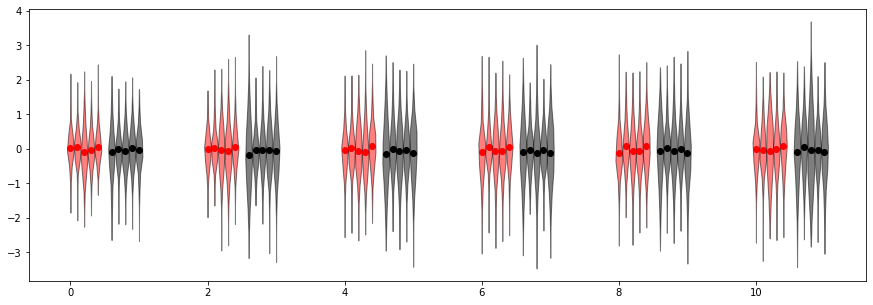

In [10]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'avg_skewness')
print(ko_means,ctrl_means)

In [11]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.033259    1    8  0.033259  1.938869  0.201273  0.195079   
1          day  0.007652    5   40  0.001530  1.348072  0.264304  0.144209   
2  Interaction  0.003359    5   40  0.000672  0.591850  0.706181  0.068885   

        eps  
0       NaN  
1  0.496174  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1 -0.016594 -0.063682  0.047088  0.014919  3.156168  0.002535  0.804336


[2.35883082 1.70477927 2.27587145 1.17369027 1.68146152 4.06024983] [0.04604218 0.1266333  0.05240796 0.27427486 0.13117876 0.00363218]
[0.04720176769014221, 0.11718508719813801, 0.07580017458236125, 0.25059205068568424, 0.17452534056858338]
[[-0.00705665  0.21049914  0.03273145 -0.03566524  0.00050513]
 [-0.02659262  0.26393751 -0.04281642 -0.07585584 -0.00206034]
 [-0.05187781  0.21376366 -0.01266032 -0.07946183  0.12389606]
 [-0.16205734  0.27140724 -0.06986241 -0.08729939  0.11789519]
 [-0.10187285  0.23485693 -0.05117525 -0.08678442  0.18276566]
 [-0.013541    0.02937567 -0.05310084 -0.02347523  0.0533407 ]] [[-0.09905994 -0.10924555 -0.12072243 -0.0919834   0.0212509 ]
 [-0.0752204  -0.14734317 -0.02567153 -0.14297222 -0.05426065]
 [-0.04894047 -0.18648709 -0.0420074  -0.14027961 -0.09806587]
 [-0.07907283 -0.19721083 -0.1139837   0.04594598 -0.10424137]
 [-0.09276971 -0.05366959 -0.02897975 -0.15426947 -0.12493101]
 [-0.10978775 -0.13308613 -0.0807408  -0.067821   -0.07527973]]


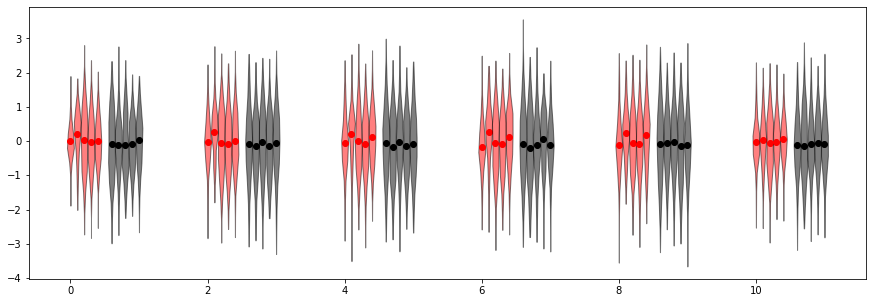

In [12]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'avg_skewness')
print(ko_means,ctrl_means)

In [13]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.202149    1    8  0.202149  4.747161  0.060977  0.372409   
1          day  0.004324    5   40  0.000865  0.222372  0.950764  0.027045   
2  Interaction  0.003858    5   40  0.000772  0.198430  0.961248  0.024203   

        eps  
0       NaN  
1  0.680621  
2       NaN  
Tukey test on groups
   A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  0.025059 -0.09103  0.116089  0.024078  4.821292    0.001  1.228685


[2.09432536 2.11491945 2.20191194 2.57814283 2.15652163 3.13337467] [0.06954868 0.06735569 0.05881828 0.03271065 0.06313061 0.01394403]
[0.07580017458236125, 0.07580017458236125, 0.028280122568276955, 0.04720176769014221, 0.07580017458236125]


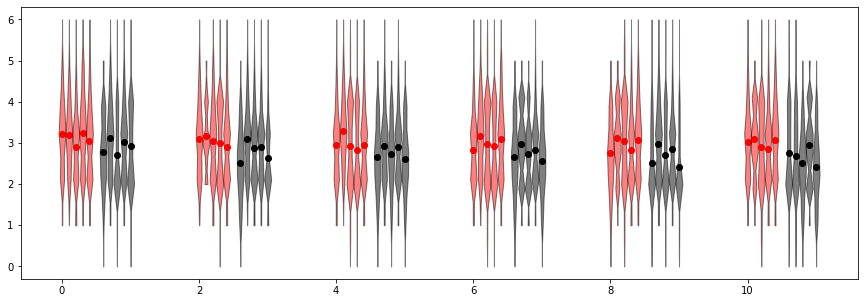

In [16]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_fam_lap_stats,ctrl_fam_lap_stats,'max_counts')

In [17]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.944296    1    8  0.944296  9.129987  0.016520  0.532983   
1          day  0.251273    5   40  0.050255  3.796349  0.006593  0.321824   
2  Interaction  0.025403    5   40  0.005081  0.383801  0.856917  0.045779   

        eps  
0       NaN  
1  0.566344  
2       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  3.015833  2.764928  0.250905  0.043333  5.790214    0.001  1.475611


[2.38593514 1.52919386 2.19389258 1.47416417 2.21562631 4.11090375] [0.04413494 0.16474241 0.05955841 0.17866612 0.05757355 0.00338641]
[0.04720176769014221, 0.34720763934942456, 0.028280122568276955, 0.34720763934942456, 0.07580017458236125]


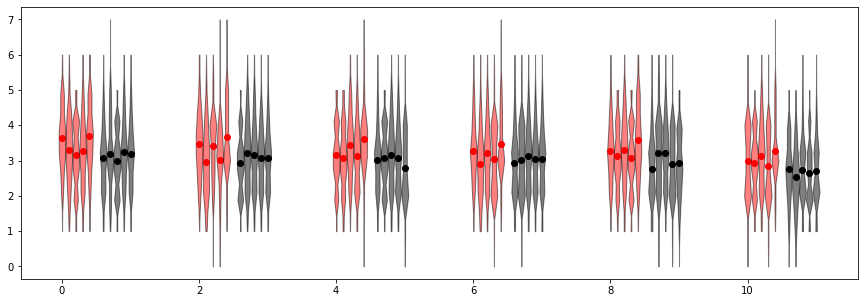

In [14]:
(fig, ax), ko_means, ctrl_means, (t,p) = avg_stats_violinplots(ko_nov_lap_stats,ctrl_nov_lap_stats,'max_counts')

In [15]:
df = {'ko_ctrl':[],
     'day':[],
     'std':[],
     'mouse':[]}

for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['std'].append(ko_means[day,mouse])
        df['mouse'].append(mouse)
        
for mouse in range(5): 
    for day in range(6):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['std'].append(ctrl_means[day,mouse])
        df['mouse'].append(mouse+5)
        
df = pd.DataFrame(df)
aov = mixed_anova(data=df,dv='std',between='ko_ctrl', within='day',subject='mouse')
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='std', between = 'ko_ctrl')
print(stats)


        Source        SS  DF1  DF2        MS          F         p-unc  \
0      ko_ctrl  0.981750    1    8  0.981750   7.368153  2.647577e-02   
1          day  1.036172    5   40  0.207234  15.163189  2.362658e-08   
2  Interaction  0.060967    5   40  0.012193   0.892181  4.955246e-01   

        np2       eps  
0  0.479443       NaN  
1  0.654624  0.665933  
2  0.100333       NaN  
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se        T  p-tukey    hedges
0  0  1  3.248858  2.993026  0.255832  0.055809  4.58405    0.001  1.168225


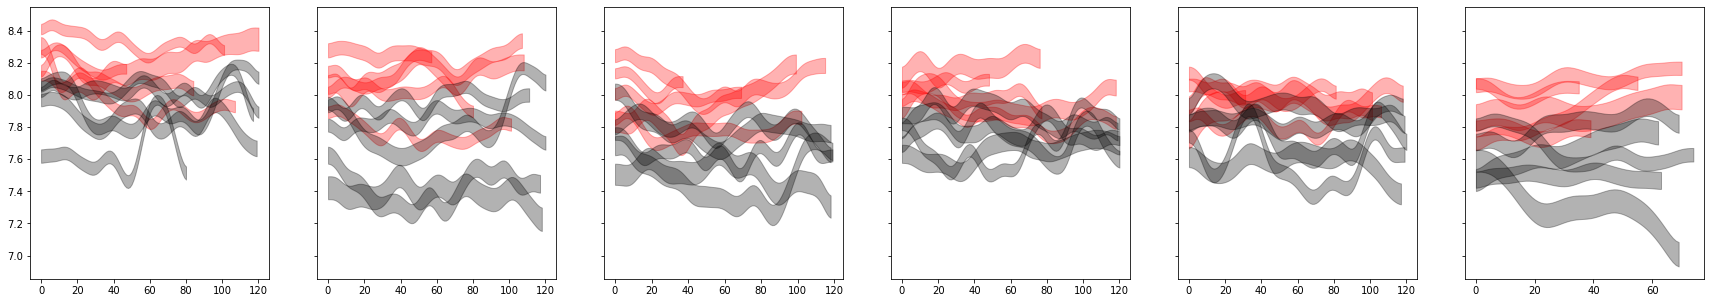

In [39]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'std'
for mouse in ko_mice:
    for day in range(6):
        std = np.squeeze(ko_fam_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='red',alpha = .3)

for mouse in ctrl_mice:
    for day in range(6):
        std = np.squeeze(ctrl_fam_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='black',alpha = .3)

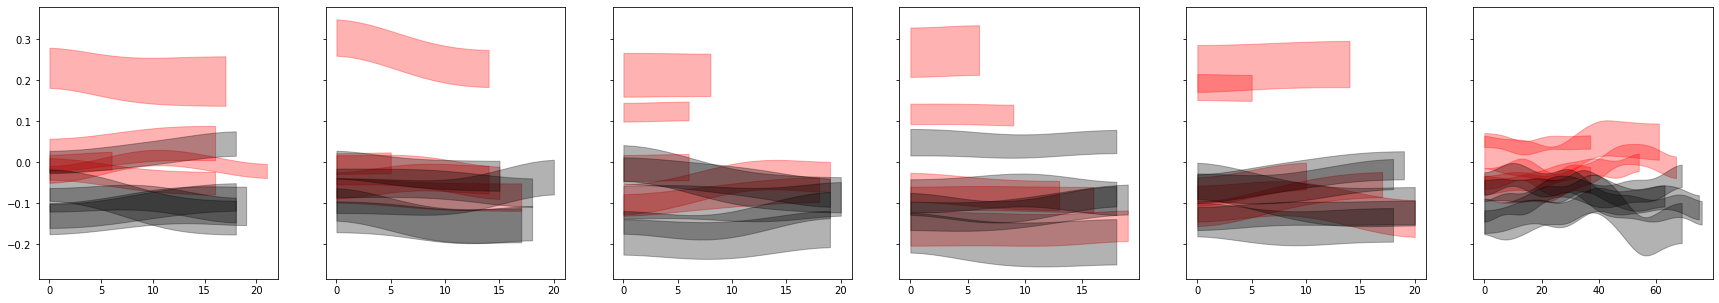

In [38]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'skewness'
for mouse in ko_mice:
    for day in range(6):
        std = np.squeeze(ko_nov_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='red',alpha = .3)

for mouse in ctrl_mice:
    for day in range(6):
        std = np.squeeze(ctrl_nov_lap_stats[mouse][day][key])

        mu, sem  = std.mean(axis=-1), sp.stats.sem(std,axis=-1)
        x = np.arange(0,mu.shape[0])

        ax[day].fill_between(x,mu-sem,mu+sem, color='black',alpha = .3)

(5139,)
(5224,)
(5482,)
(5140,)
(4700,)
(4809,)
(5960,)
(4647,)
(4669,)
(5049,)
(4845,)
(4705,)


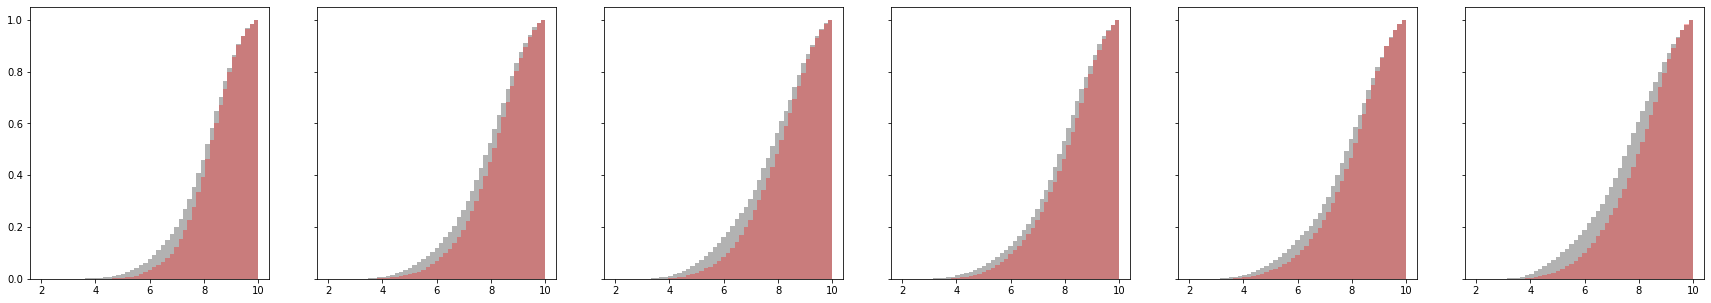

In [52]:
fig,ax = plt.subplots(1,6, figsize = [30,5],sharey=True)
key = 'avg_std'


for day in range(6):
    std = []
    for mouse in ko_mice:
        std.append(np.squeeze(ko_fam_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.linspace(2,10,num=50)
    ax[day].hist(std,bins=bins,color='red',density=True, alpha=.3,cumulative=True)

for day in range(6):
    std = []
    for mouse in ctrl_mice:
        std.append(np.squeeze(ctrl_fam_lap_stats[mouse][day][key]))
    std = np.concatenate(std).ravel()  
    print(std.shape)
    bins = np.linspace(2,10,num=50)
    ax[day].hist(std,bins=bins,color='black',density=True, alpha=.3,cumulative=True, zorder= -1)


In [17]:


def within_day_slopes(ko_dict,ctrl_dict, key,day):
    fig,ax = plt.subplots()
    bins = np.linspace(-.05,.05,num=20)
    ko_slopes =[]
    for mouse in ko_mice:
        x = np.arange(ko_dict[mouse][day][key].shape[0])
        ncells = ko_dict[mouse][day][key].shape[-1]
        slopes = []
        arr = np.squeeze(ko_dict[mouse][day][key])
        for cell in range(ncells):

            res = sp.stats.linregress(x,arr[:,cell])
            slopes.append(res.slope)
        #     ax.scatter(x,ko_lap_stats[mouse][day]['skewness'][:,cell])
        ax.hist(slopes,bins=bins,cumulative=False, alpha = .3,color='red',density=True)
#         ko_slopes.append(np.median(np.array(slopes)))
        ko_slopes.append(slopes)

    ctrl_slopes =[]
    for mouse in ctrl_mice:
        x = np.arange(ctrl_dict[mouse][day][key].shape[0])
        ncells = ctrl_dict[mouse][day][key].shape[-1]
        slopes = []
        arr = np.squeeze(ctrl_dict[mouse][day][key])
        for cell in range(ncells):
            res = sp.stats.linregress(x,arr[:,cell])
            slopes.append(res.slope)
        ax.hist(slopes,bins=bins,cumulative=False,alpha=.3,color='black', density=True, fill=False)
#         ctrl_slopes.append(np.median(np.array(slopes)))
        ctrl_slopes.append(slopes)
    
    return ko_slopes, ctrl_slopes

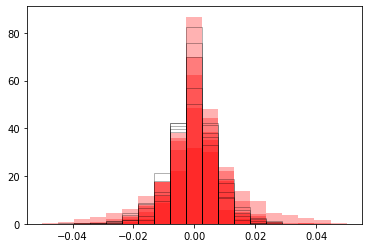

In [21]:
ko_slopes, ctrl_slopes = within_day_slopes(ko_fam_lap_stats,ctrl_fam_lap_stats, 'skewness', 0)

In [22]:
ko_slopes,ctrl_slopes = np.concatenate(ko_slopes), np.concatenate(ctrl_slopes)

(array([0.00000000e+00, 6.37583893e-02, 6.37583893e-02, 1.91275168e-01,
        8.28859060e-01, 2.39093960e+00, 5.83389262e+00, 1.50151007e+01,
        4.05503356e+01, 6.64681208e+01, 3.81912752e+01, 1.41862416e+01,
        4.55872483e+00, 1.27516779e+00, 3.82550336e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([-0.05      , -0.04473684, -0.03947368, -0.03421053, -0.02894737,
        -0.02368421, -0.01842105, -0.01315789, -0.00789474, -0.00263158,
         0.00263158,  0.00789474,  0.01315789,  0.01842105,  0.02368421,
         0.02894737,  0.03421053,  0.03947368,  0.04473684,  0.05      ]),
 <BarContainer object of 19 artists>)

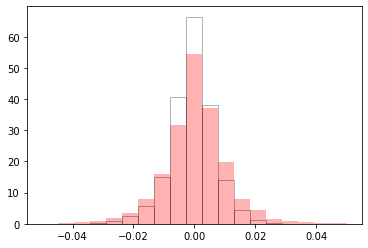

In [27]:
fig, ax= plt.subplots()
bins =  np.linspace(-.05,.05,num=20)
ax.hist(ko_slopes, bins = bins, alpha=.3, color='red', density = True)
ax.hist(ctrl_slopes, bins = bins, alpha = .3, color='black', fill=False, density=True)

[ 0.01147722  0.00197848 -0.01699375 ... -0.00262956  0.00820931
  0.00034655] [ 0.00654734 -0.0063852  -0.0030401  ...  0.00594976  0.00894234
  0.0001971 ]
0.0005533820526681838 -0.00047518695641456874
5.9963505600389055 2.0808813891296643e-09


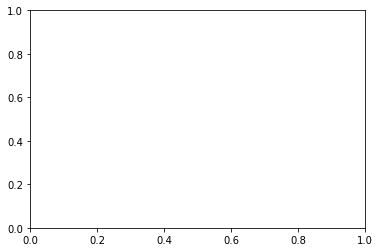

In [31]:
print(ko_slopes,ctrl_slopes)
# fig, ax = plt.subplots()
# ax.scatter(np.zeros([5,]),ko_slopes, color = 'red')
# ax.scatter(np.ones([5,]), ctrl_slopes, color = 'black')
t,p = sp.stats.ttest_ind(ko_slopes,ctrl_slopes)
print(ko_slopes.mean(),ctrl_slopes.mean())
print(t,p)

1.1489125293076057 0.25059205068568424
[0.07401914858563588, -0.010673892384329458, -0.09809339143535742, -0.09969436052606515, 0.02709371228467785] [-0.11564610095231817, -0.03204033646592791, -0.14970843626475352, -0.0027470879785588763, -0.03672304647944644]


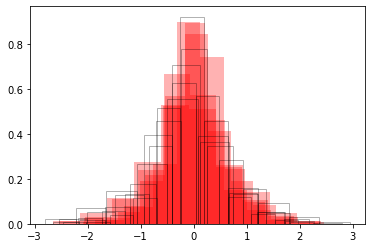

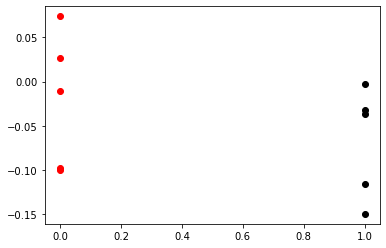

In [33]:
def last_trials_avg(ko_dict,ctrl_dict, key,day):
    fig,ax = plt.subplots()
    bins = np.linspace(-.05,.05,num=20)
    ko_avg =[]
    for mouse in ko_mice:
        x = np.arange(ko_dict[mouse][day][key].shape[0])
        ncells = ko_dict[mouse][day][key].shape[-1]
        slopes = []
        arr = np.squeeze(ko_dict[mouse][day][key])
#         for cell in range(ncells):

#             res = sp.stats.linregress(x,arr[:,cell])
#             ax.hist(arr[:,,cumulative=False, alpha = .3,color='red',density=True)
        ax.hist(arr[-5:,:].mean(axis=0), density = True, color='red', alpha=.3)
        ko_avg.append(np.median(arr[-5:,:].mean(axis=0)))
#         ko_slopes.append(np.median(np.array(slopes)))

    ctrl_avg =[]
    for mouse in ctrl_mice:
        x = np.arange(ctrl_dict[mouse][day][key].shape[0])
        ncells = ctrl_dict[mouse][day][key].shape[-1]
        slopes = []
        arr = np.squeeze(ctrl_dict[mouse][day][key])
        ax.hist(arr[-5:,:].mean(axis=0), density = True, color='black', alpha=.3, fill=False)
        ctrl_avg.append(np.median(arr[-5:,:].mean(axis=0)))
    
    return ko_avg, ctrl_avg

# mouse = ko_mice[2]
# day = 0
# key = 'skewness'

# arr = np.squeeze(ko_fam_lap_stats[mouse][day][key])

# fig,ax = plt.subplots()
# ax.hist(arr[-10:,:].mean(axis=0))
# arr[-10:,:].mean(axis=0).mean()

ko_mu, ctrl_mu = last_trials_avg(ko_fam_lap_stats, ctrl_fam_lap_stats, 'skewness', 0)
t,p = sp.stats.ranksums(ko_mu, ctrl_mu)

print(t,p)
fig, ax = plt.subplots()
print(ko_mu, ctrl_mu)
ax.scatter(np.zeros([5,]),ko_mu, color = 'red')
ax.scatter(np.ones([5,]), ctrl_mu, color = 'black')


In [45]:

def peri_max_plot(sess):

    cellmask, _ = place_cell_masks(sess)
    cellmask = cellmask>-10

    trialmask = sess.trial_info['LR']==-1*sess.novel_arm

    trial_mat = sess.trial_matrices['spks_norm'][:,:,cellmask]
    trial_mat = trial_mat[trialmask,:,:]
    print(trial_mat.shape)
    trial_mat[np.isnan(trial_mat)]=1E-5
    avg_trial_mat = trial_mat[:,:,:].mean(axis=0,keepdims=True)

    max_inds = np.argmax(avg_trial_mat,axis=1).ravel()

    
    early_peri_max_act = np.zeros([max_inds.shape[0],15])*np.nan
    late_peri_max_act = np.zeros([max_inds.shape[0],15])*np.nan
    for cell in range(max_inds.shape[0]):
        left = np.maximum(0,max_inds[cell]-7)
        left_offset = -1*np.minimum(0,max_inds[cell]-7)


        right = np.minimum(max_inds[cell]+8, 30)
        right_offset = -1*np.minimum(30 - (max_inds[cell]+8), 0)
    #     print(max_inds[cell],left,right, left_offset, right_offset)
    #     print(14-right_offset)
    #     print(peri_max_act[cell,left_offset:15- right_offset].shape, trial_mat[:10,left:right+1,cell].mean(axis=0).shape)
        early_peri_max_act[cell,left_offset:15- right_offset] = trial_mat[:10,left:right,cell].mean(axis=0)
        late_peri_max_act[cell,left_offset:15- right_offset] = trial_mat[-10:,left:right,cell].mean(axis=0)
    return early_peri_max_act, late_peri_max_act

ko_peri_max = {mouse:peri_max_plot(u.load_single_day(mouse,day=0)) for mouse in ko_mice}
ctrl_peri_max = {mouse:peri_max_plot(u.load_single_day(mouse,day=0)) for mouse in ctrl_mice}




{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus2/2P_Data/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


(102, 30, 1318)
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
(121, 30, 332)
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
(85, 30, 1197)
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
(108, 30, 1659)
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
(48, 30, 1911)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
(120, 30, 1381)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 0}
(121, 30, 1283)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel': -1, 'ravel_ind': 0}
(118, 30, 1568)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel': 1, 'ravel_ind': 1}
(81, 30, 1694)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel',

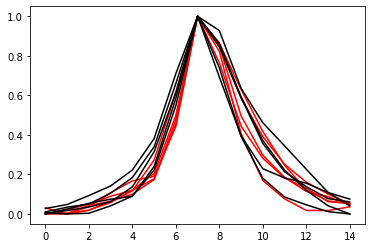

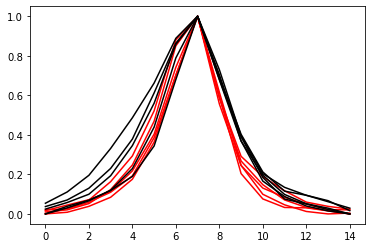

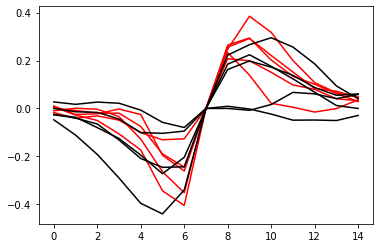

In [46]:
fig, ax = plt.subplots()
for mouse, data in ko_peri_max.items():
    mu = np.nanmean(data[0], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    ax.plot((mu-_min)/(_max-_min), color='red')
    
for mouse, data in ctrl_peri_max.items():
    mu = np.nanmean(data[0], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    ax.plot((mu-_min)/(_max-_min), color='black')
    
    
fig, ax = plt.subplots()
for mouse, data in ko_peri_max.items():
    mu = np.nanmean(data[1], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    ax.plot((mu-_min)/(_max-_min), color='red')
    
for mouse, data in ctrl_peri_max.items():
    mu = np.nanmean(data[1], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    ax.plot((mu-_min)/(_max-_min), color='black')
    
    
fig, ax = plt.subplots()
for mouse, data in ko_peri_max.items():
    
    mu = np.nanmean(data[0], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    arr0 = (mu-_min)/(_max-_min)
    
    mu = np.nanmean(data[1], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    arr1 = (mu-_min)/(_max-_min)
    
    ax.plot(arr0-arr1, color='red')
    
for mouse, data in ctrl_peri_max.items():
    mu = np.nanmean(data[0], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    arr0 = (mu-_min)/(_max-_min)
    
    mu = np.nanmean(data[1], axis=0)
    _min, _max = np.amin(mu), np.amax(mu)
    arr1 = (mu-_min)/(_max-_min)
    
    ax.plot(arr0-arr1, color='black')

In [35]:
sess = u.load_single_day(ctrl_mice[4],day=3)
# sess = u.single_mouse_concat_sessions(ko_mice[0],date_inds = np.arange(0,2))
fam = True
if fam:
    cellmask, _ = place_cell_masks(sess)
    cellmask = np.ones(cellmask.shape)>0
    trialmask = sess.trial_info['LR']==-1*sess.novel_arm

else:
    _,cellmask = place_cell_masks(sess)
    cellmask = np.ones(cellmask.shape)>0
    trialmask = sess.trial_info['LR']==sess.novel_arm
        
        
trial_mat = sess.trial_matrices['spks'][:,:,cellmask]
trial_mat[np.isnan(trial_mat)]=1E-5
trial_mat = trial_mat[trialmask,:,:]
trial_mat_norm = trial_mat/(np.nansum(trial_mat, axis=1,keepdims=True)+1E-5)

avg_trial_mat = trial_mat.mean(axis=0,keepdims=True)
# avg_trial_mat = sp.ndimage.filters.gaussian_filter1d(avg_trial_mat,1,axis=1)
avg_trial_mat_norm = avg_trial_mat/(avg_trial_mat.sum(axis=1,keepdims=True)+1E-5)
print(avg_trial_mat_norm.shape)

inds = np.arange(0,trial_mat.shape[1])[np.newaxis, :, np.newaxis]
    
com = (trial_mat_norm*inds).sum(axis=1,keepdims=True)
std = np.power((np.power(inds - com,2)*trial_mat_norm).sum(axis=1,keepdims=True),.5)
print(com.shape, std.shape)

avg_com = (avg_trial_mat_norm*inds).sum(axis=1,keepdims=True)
avg_std = np.power((np.power(inds - avg_com,2)*avg_trial_mat_norm).sum(axis=1,keepdims=True),.5)

skewness = (np.power((inds-avg_com)/avg_std,3)*avg_trial_mat_norm).sum(axis=1)
print(skewness.shape)

{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
(1, 30, 1467)
(121, 1, 1467) (121, 1, 1467)
(1, 1467)


(array([  2.,  19.,  53., 120., 291., 490., 338., 109.,  35.,  10.]),
 array([-3.16320915, -2.60191764, -2.04062613, -1.47933462, -0.91804311,
        -0.35675159,  0.20453992,  0.76583143,  1.32712294,  1.88841445,
         2.44970596]),
 <BarContainer object of 10 artists>)

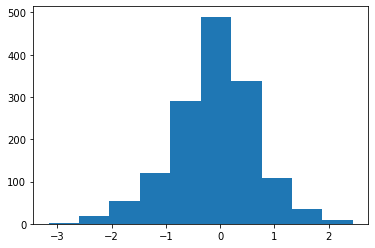

In [66]:
fig,ax = plt.subplots()
ax.hist(skewness.ravel())
# ax.plot(skewness.mean(axis=-1))

<ipython-input-67-d84c1b3dd47f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


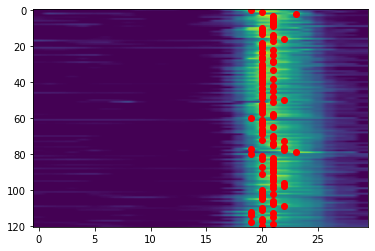

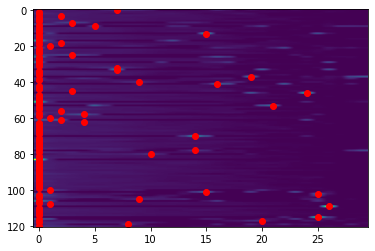

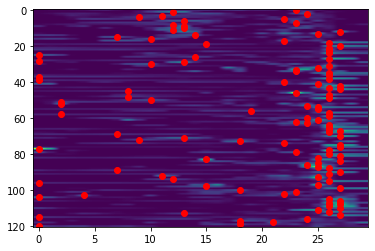

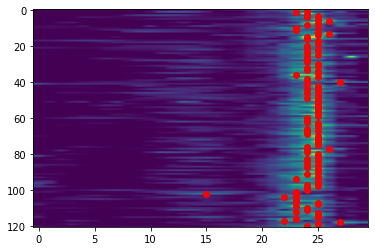

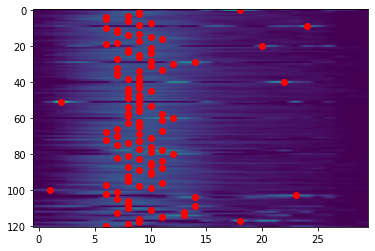

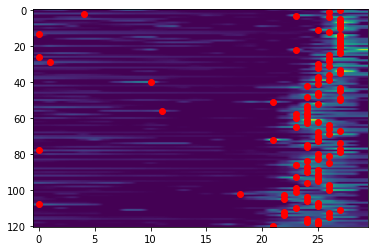

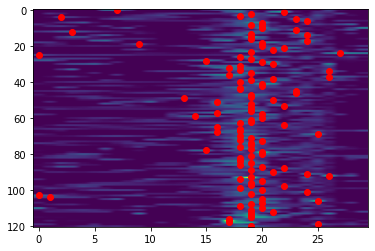

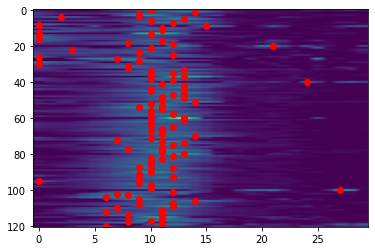

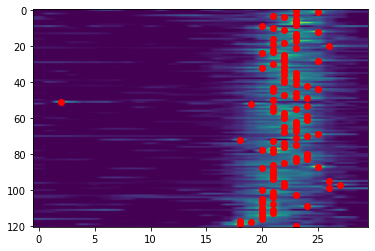

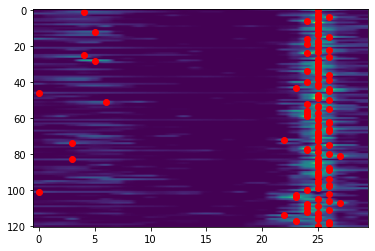

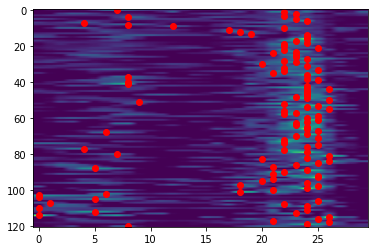

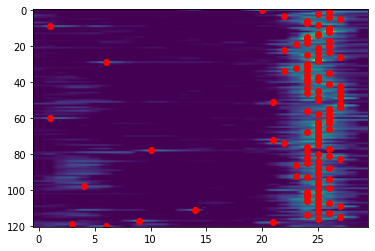

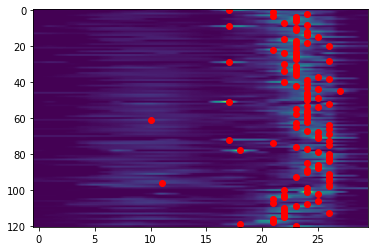

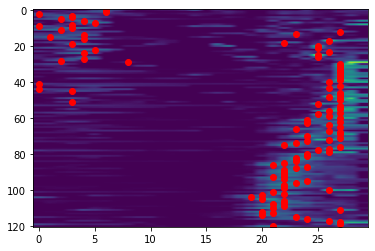

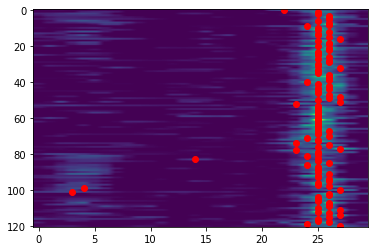

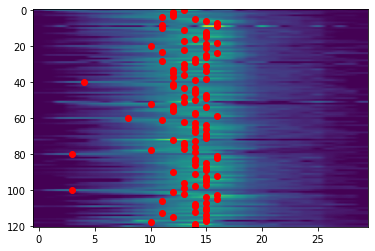

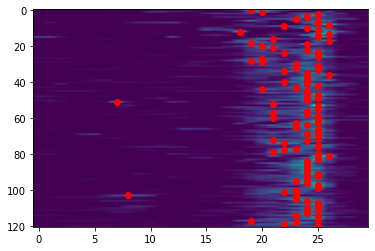

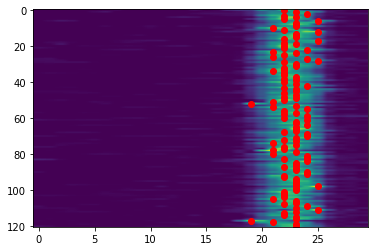

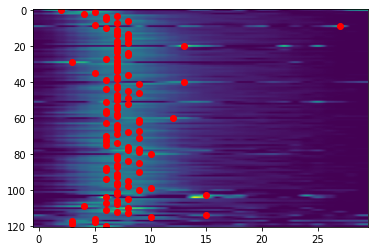

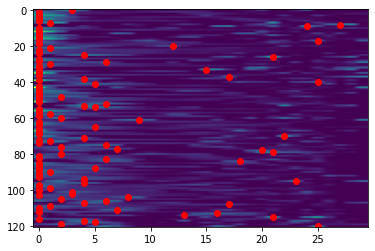

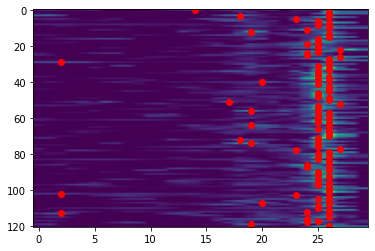

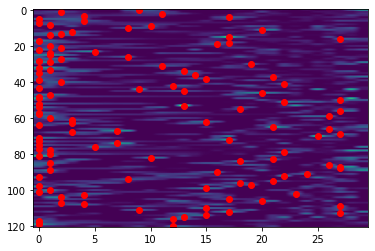

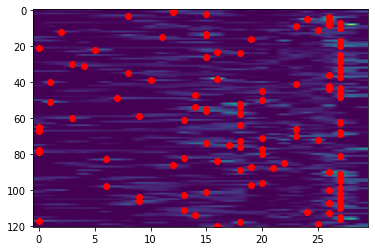

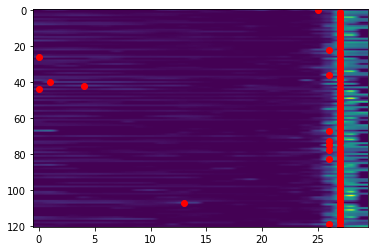

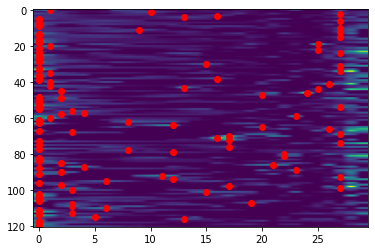

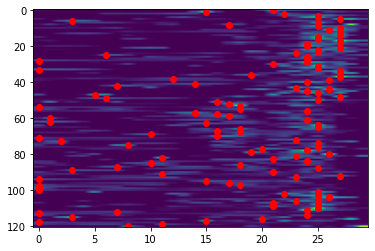

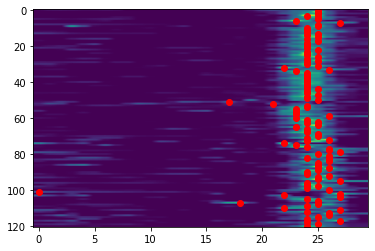

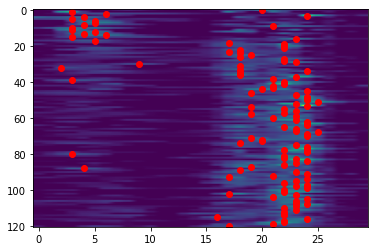

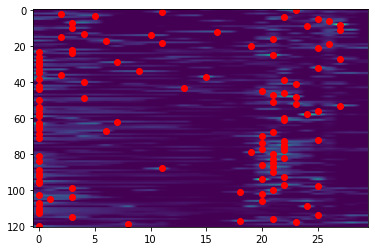

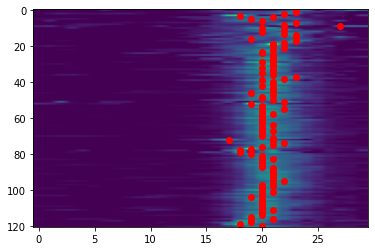

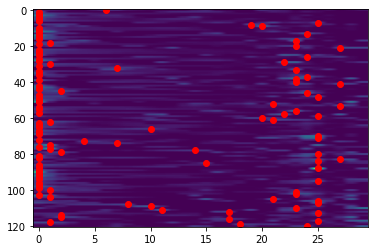

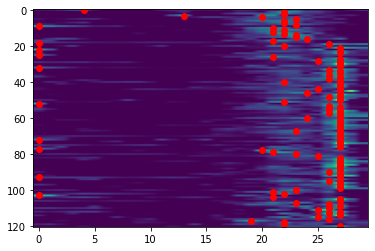

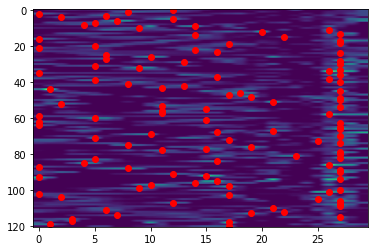

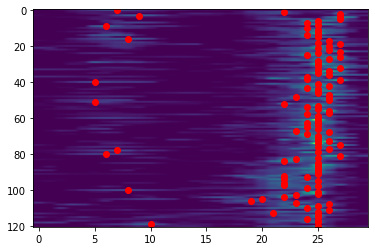

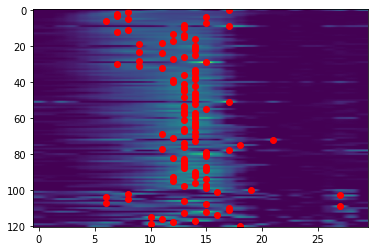

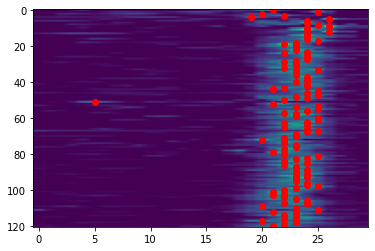

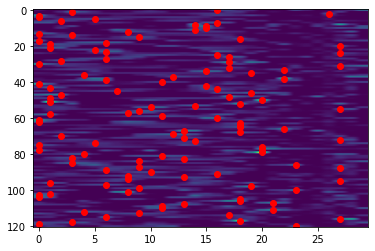

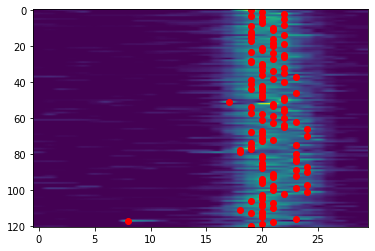

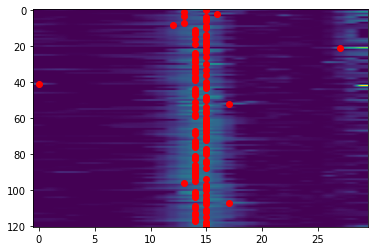

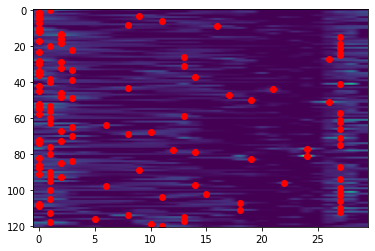

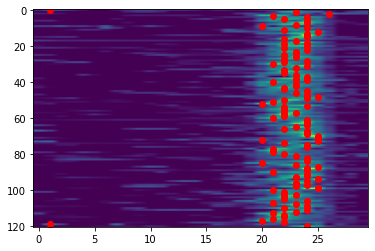

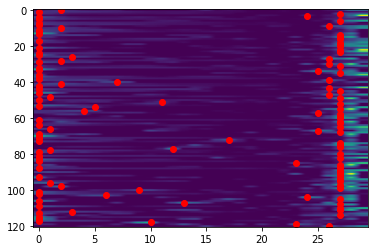

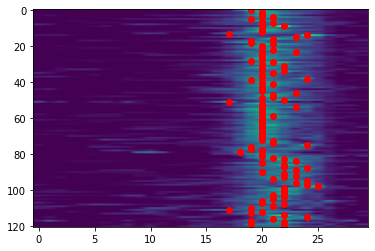

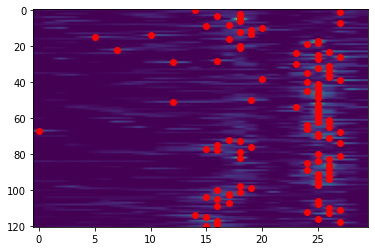

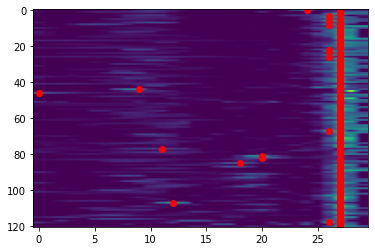

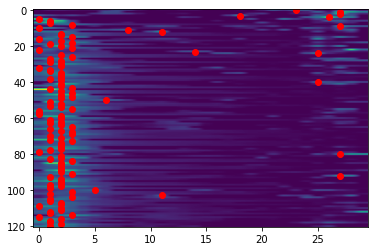

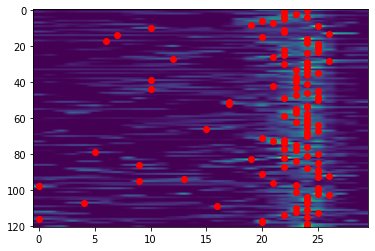

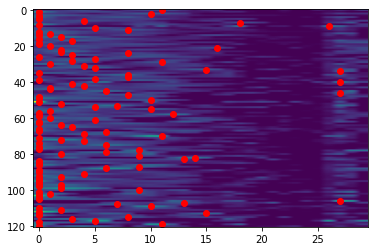

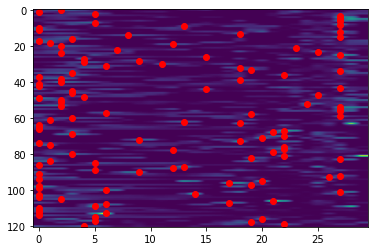

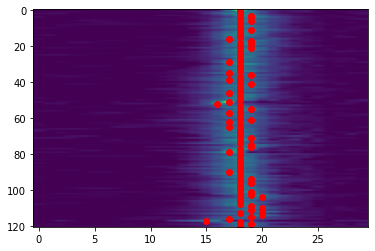

In [67]:
for cell in range(50):
    fig,ax = plt.subplots()
    tm = trial_mat_norm[:,:,cell]
    maxmask = np.zeros(tm.shape)
    
    
    ax.imshow(tm,aspect='auto')
    ax.scatter(np.argmax(tm[:,:-2],axis=1), np.arange(0,tm.shape[0]),color='red')
#     ax.imshow(maxmask,alpha=.3,aspect='auto',cmap='Reds')

(array([ 4,  7, 21]),)
(array([28]),)
(array([ 2,  8, 10, 13, 26]),)
(array([14, 25]),)
(array([9]),)
(array([10, 26]),)
(array([ 3,  6,  9, 19, 24]),)
(array([11, 28]),)
(array([ 2,  6,  9, 23]),)
(array([ 4, 12, 25]),)
(array([ 7, 24]),)
(array([ 3, 10, 14, 17, 25]),)
(array([10, 24]),)
(array([ 3, 14, 23, 28]),)
(array([ 4, 15, 25]),)
(array([14]),)
(array([ 1,  7, 12, 15, 25]),)
(array([ 5, 11, 13, 23]),)
(array([7]),)
(array([13, 20, 23, 28]),)
(array([ 1,  5,  7, 10, 14, 19, 26]),)
(array([13, 19, 22, 27]),)
(array([ 4, 15, 17, 20, 28]),)


<ipython-input-68-1cd62f29fcf3>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


(array([ 1, 28]),)
(array([28]),)


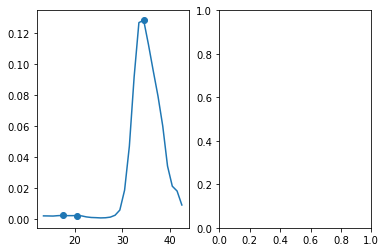

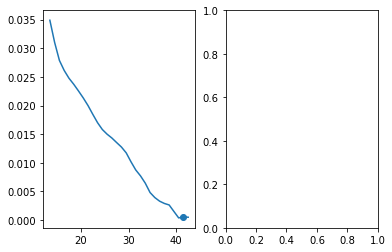

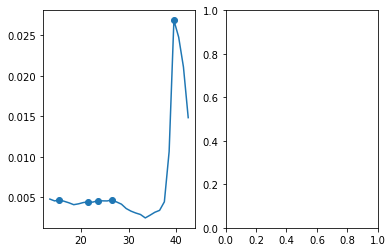

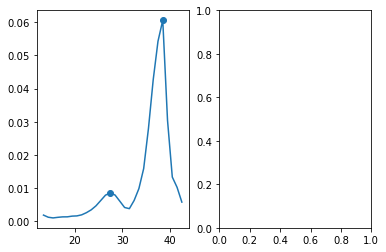

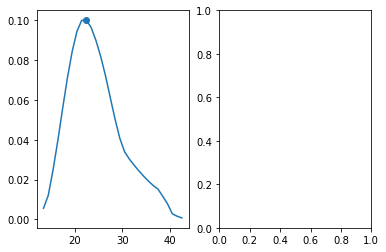

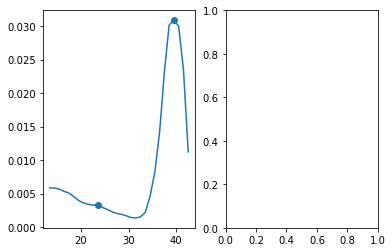

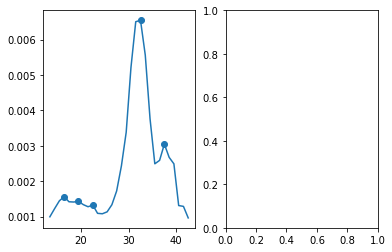

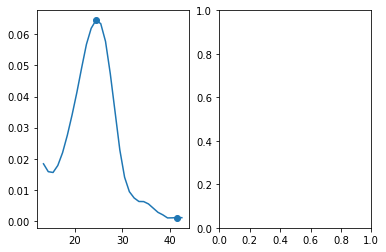

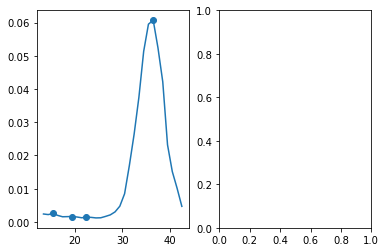

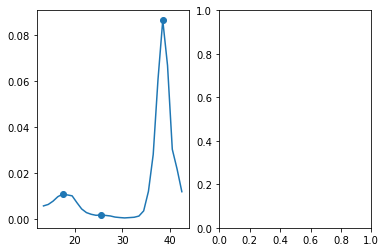

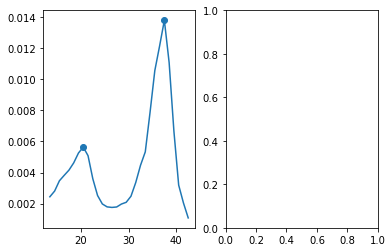

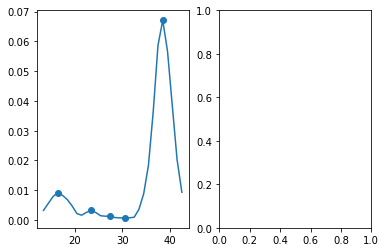

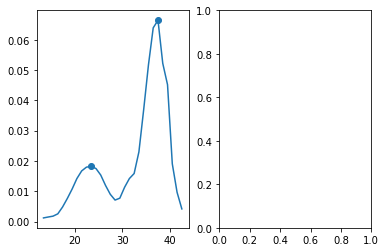

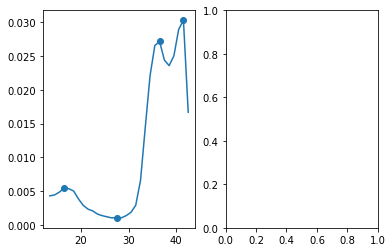

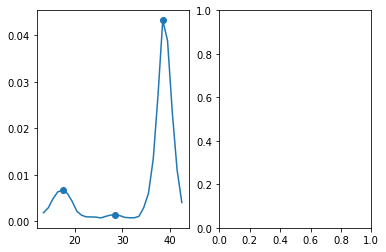

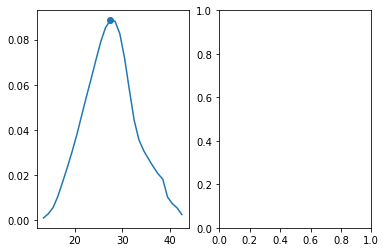

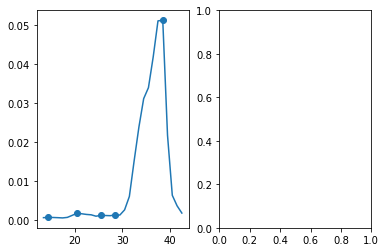

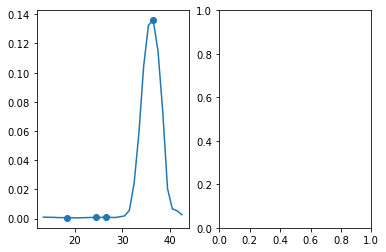

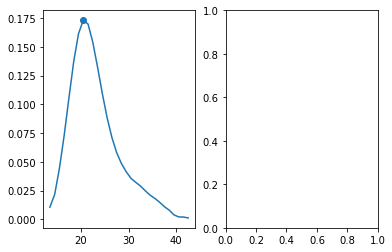

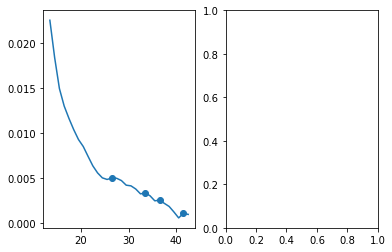

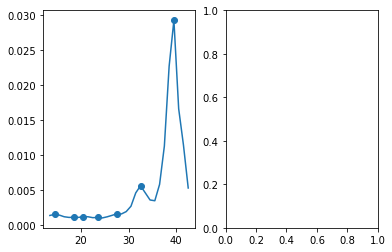

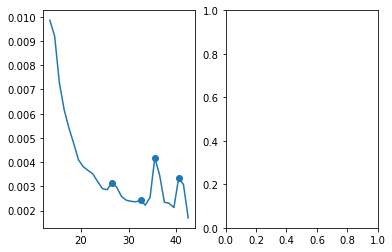

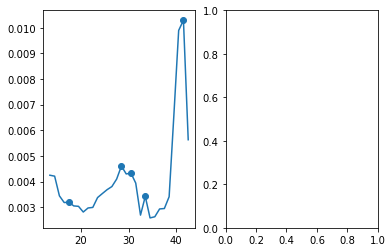

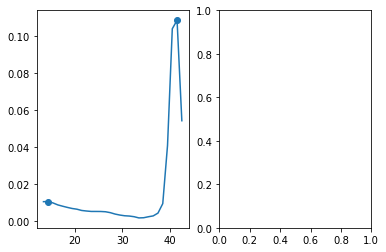

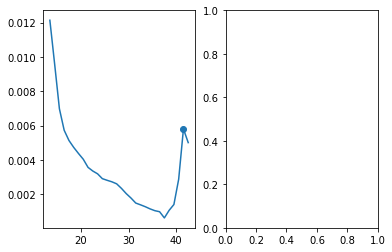

In [68]:
for cell in range(25):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(sess.trial_matrices['bin_centers'],avg_trial_mat[0,:,cell])
    print(sp.signal.argrelmax(avg_trial_mat[0,:,cell]))
    argmax = sp.signal.argrelmax(avg_trial_mat[0,:,cell])[0]
    
    ax[0].scatter(sess.trial_matrices['bin_centers'][argmax],avg_trial_mat[0,argmax,cell])
#     ax[0].scatter(sess.trial_matrices['bin_centers'][peak_inds[0,cell]], norm_rate_map[peak_inds[0,cell],cell])
    
#     ax[0].scatter(sess.trial_matrices['bin_centers'][left_edge[cell]], norm_rate_map[left_edge[cell],cell])
#     r_edge = np.minimum(29,right_edge[cell])
#     ax[0].scatter(sess.trial_matrices['bin_centers'][r_edge], norm_rate_map[r_edge,cell])
    
    
#     ax[1].scatter(np.arange(0,trial_mat.shape[0]),oof_rat[:,cell])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False]
[ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True 

<ipython-input-25-5b84f08ce5d1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


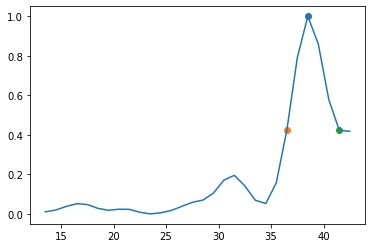

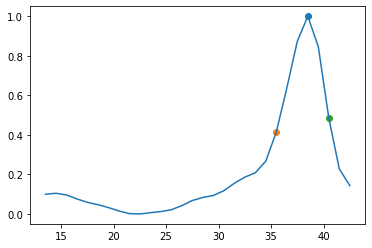

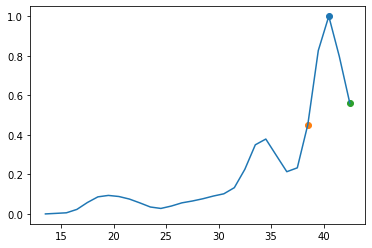

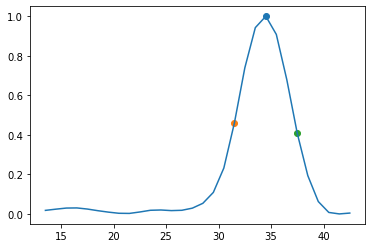

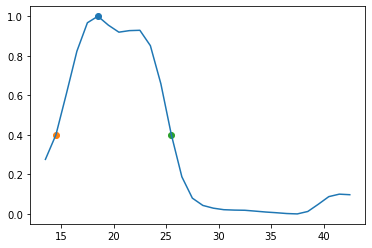

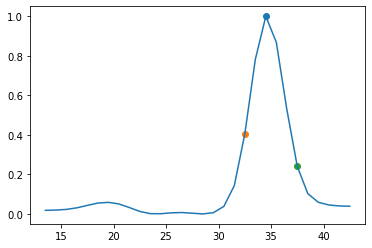

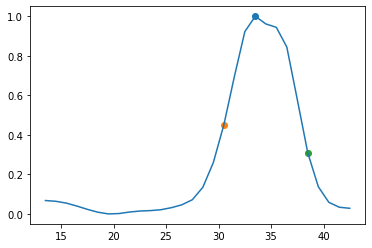

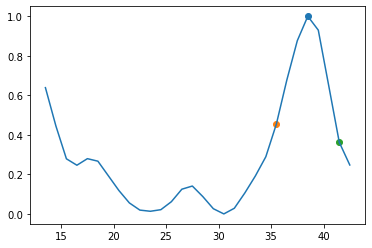

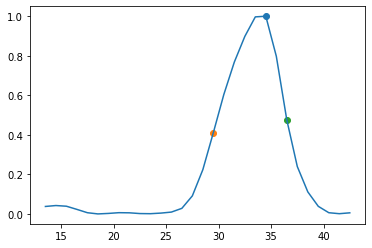

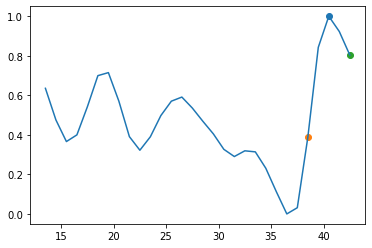

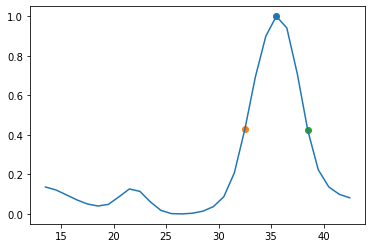

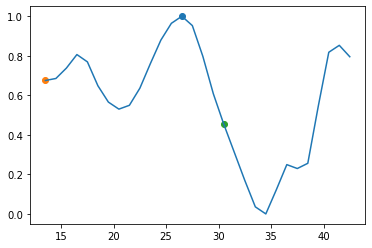

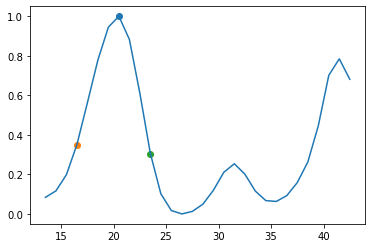

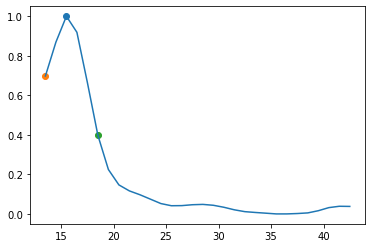

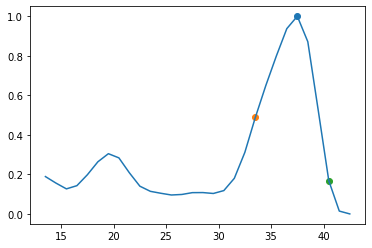

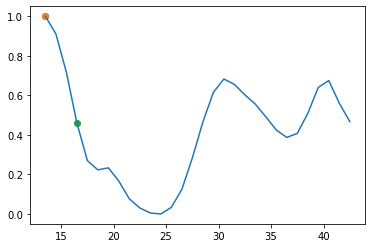

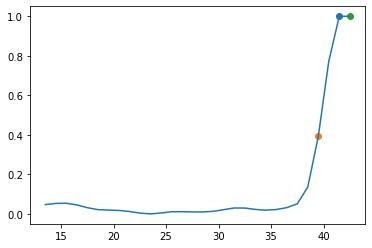

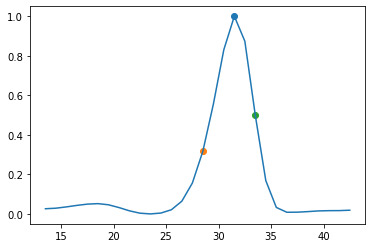

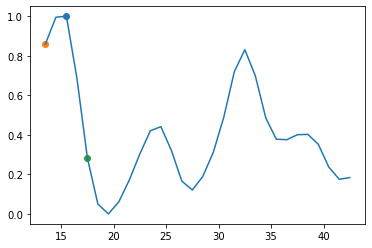

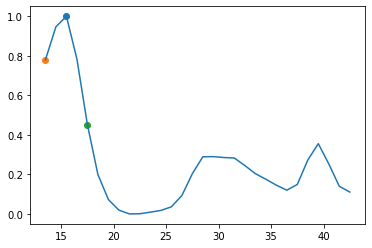

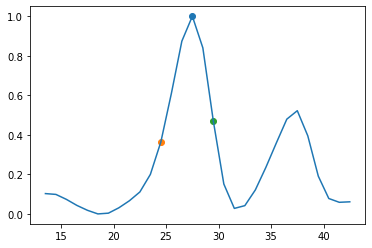

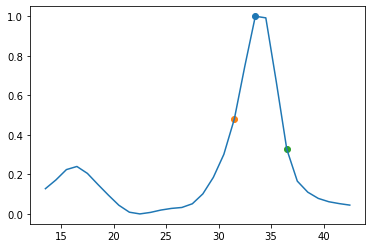

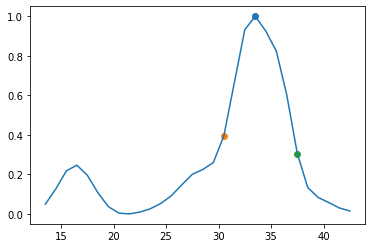

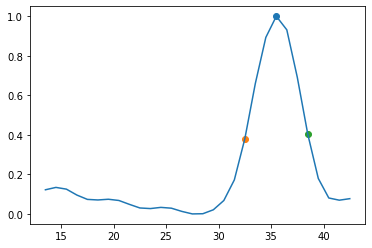

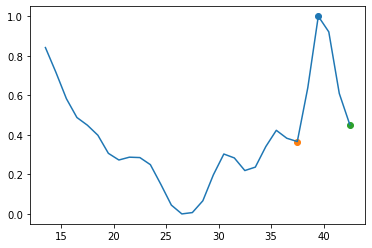

In [25]:
for cell in range(25):
    fig, ax = plt.subplots()
    ax.plot(sess.trial_matrices['bin_centers'],norm_rate_map[:,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][peak_inds[cell]], norm_rate_map[peak_inds[cell],cell])
    
    half_max = norm_rate_map[:,cell]<=.5
    left_mask = half_max*(np.arange(0,norm_rate_map.shape[0])<peak_inds[cell])
    print(left_mask)
    if left_mask.sum()>0:
        left_edge = np.argwhere(left_mask)[-1]
    else:
        left_edge = 0
        
    right_mask = half_max*(np.arange(0,norm_rate_map.shape[0])>peak_inds[cell])
    if right_mask.sum()>0:
        right_edge = np.argwhere(right_mask)[0]
    else:
        right_edge = avg_rate_map.shape[0]-1
    
    ax.scatter(sess.trial_matrices['bin_centers'][left_edge], norm_rate_map[left_edge,cell])
    ax.scatter(sess.trial_matrices['bin_centers'][right_edge], norm_rate_map[right_edge,cell])

In [ ]:
# within-day 


# get familiar arm place cells


# find peak based on average

# define field as FWHM of peak

    # save width
    
# out of field normalized activity rate per trial

# spatial variance of firing rate